# PyHDX basics

In [1]:
from pyhdx import PeptideMasterTable, read_dynamx, HDXMeasurement
from pyhdx.plot import plot_peptides
import matplotlib.pyplot as plt
from pathlib import Path

We can use the ``read_dynamx`` function to read the input DynamX state file. Exposure times in the .csv files are in the
field exposure, and we specify the unit with the `time_unit` keyword argument. The exposure time units are converted to
seconds.

This function returns a ``numpy`` structured array where each entry corresponds to one peptide, in this example 567 peptides.

In [2]:
fpath = Path() / '..' / '..' / 'tests' / 'test_data' / 'ecSecB_apo.csv'
data = read_dynamx(fpath, time_unit='min')
data.size

567

This array is loaded into the ``PeptideMasterTable`` class, which is the main data entry class. The parameter ``drop_first``
determines how many N-terminal residues are considered to be fully back-exchanged, and therefore is subtracted from the
total amount of exchangable D per peptide. The parameter ``ignore_prolines`` is controls whether the number of Prolines
residues in the peptide should be subtracted from the total amount of exchangable and should generally be set to ``True``.

The final number of exchangable residues is found in the 'ex_residues' field.

In [3]:
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.data['ex_residues'][:50]

array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 13., 13., 13., 13., 13., 13., 13., 13., 13., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 20., 20., 20., 20., 20.])

This master table allows us to control how the deuterium uptake content is determined. The method ``set_control`` can be
used to choose which set of peptides is used as the fully deuterated (FD) control. This adds a new field called 'uptake'
which is the normalized (to 100%) deuterium uptake of each peptide, with respect to the total amount of exchanging residues.

In [6]:
master_table.set_control(('Full deuteration control', 0.167*60))
master_table.data['uptake'][:50]

array([ 0.      ,  0.      ,  5.0734  ,  2.486444,  2.857141,  3.145738,
        3.785886,  4.08295 ,  4.790625,  0.      ,  0.      ,  3.642506,
        1.651437,  1.860919,  2.107151,  2.698036,  2.874801,  3.449561,
        0.      ,  0.      ,  5.264543,  1.839924,  2.508343,  2.969332,
        3.399092,  3.485568,  4.318144,  0.      ,  0.      ,  6.3179  ,
        2.532099,  3.306167,  3.996718,  4.38941 ,  4.379495,  5.283969,
        0.      ,  0.      ,  6.812215,  3.11985 ,  3.874881,  4.342807,
        4.854057,  4.835639,  5.780219,  0.      ,  0.      , 10.8151  ,
        5.432395,  6.1318  ])

Next we'll select our state of interest from the master Table. The available states are listed in `master_table.states`.
Using `get_state` allows us to select all entries which belong to this state.

In [7]:
master_table.states
state_data = master_table.get_state('SecB WT apo')
state_data.size


441

This `data` array can now be used to create an ``HDXMeasurement`` object, the main data object in PyHDX.
Experimental metadata such as labelling pH and temperature can be specified. These quantities are required for calculating
intrinsic exchange rates and ΔG values. The pH values are uncorrected values are measured by the pH meter (ie p(H, D)
values)

In [8]:
hdxm = HDXMeasurement(state_data, temperature=303.15, pH=8., name='My HDX measurement')
type(hdxm), len(hdxm), hdxm.timepoints, hdxm.name, hdxm.state

(pyhdx.models.HDXMeasurement,
 7,
 array([   0.     ,   10.02   ,   30.     ,   60.     ,  300.     ,
         600.     , 6000.00048]),
 'My HDX measurement',
 'SecB WT apo')

Iterating over a ``HDXMeasurement`` object returns a set of ``HDXTimepoint`` each with their own attributes describing
the topology of the coverage. When creating the object, peptides which are not present in all timepoints are removed, such
that all timepoints and ``HDXTimepoint`` have identical coverage.

Note that the internal time units in PyHDX are seconds.

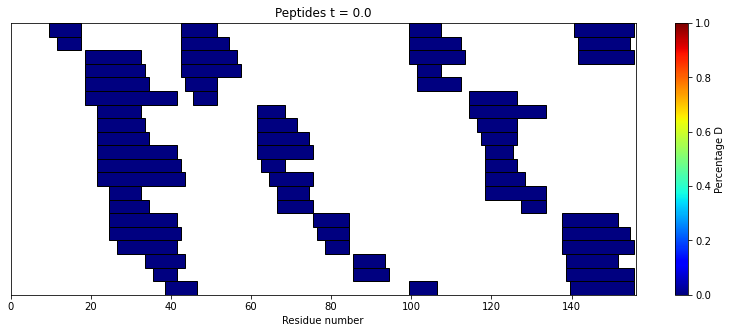

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))
i = 0
plot_peptides(hdxm[i], ax, 20, cbar=True)
t = ax.set_title(f'Peptides t = {hdxm.timepoints[i]}')
l = ax.set_xlabel('Residue number')

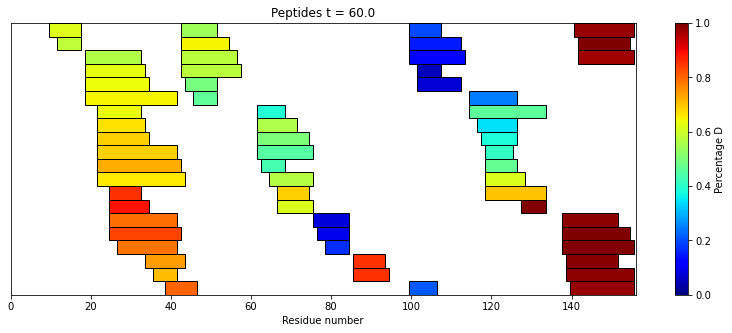

In [10]:
fig, ax = plt.subplots(figsize=(14, 5))
i = 3
plot_peptides(hdxm[i], ax, 20, cbar=True)
t = ax.set_title(f'Peptides t = {hdxm.timepoints[i]}')
l = ax.set_xlabel('Residue number')

The data in an ``HDXMeasurement`` object can be saved to and reloaded from disk (with associated metadata)
in .csv format.

In [11]:
from pyhdx.fileIO import csv_to_hdxm

hdxm.to_file('My_HDX_file.csv')
hdx_load = csv_to_hdxm('My_HDX_file.csv')
